In [1]:
# # 1. Environment

import gc
import random
import os
import timm
import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch import optim
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from swin_transformer_v2 import SwinTransformerV2


# set random seeds to make results reproducible
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)


warnings.filterwarnings("ignore")
plt.rcParams.update({'axes.titlesize': 20})


In [2]:
# ##  Arguments

# We put hyperparameter together for easy modification.

class Args:
    def __init__(self) -> None:
        # data arguments
        self.num_classes = 2
        self.img_size = 224
        self.num_train_data = 10000
        self.num_test_data = 2000
        self.dataset_path = "../input/mixed/"
        
        # training arguments
        self.learning_rate =  1e-4
        self.epochs = 30
        self.scheduler = True
        self.sch_step_size = 2
        self.sch_gamma = 0.1
        
        # model arguments
        self.drop_path_rate = 0.2
        self.embed_dim = 96
        self.depths = (2, 2, 6, 2)
        self.num_heads = (3, 6, 12, 24)
        self.window_size = 16
        # self.load_model_path = "../input/swinv2_tiny_patch4_window16_256.pth"
        self.save_model_path = "../output/mixed_vit_base_patch16_224.pth"
        
        # output arguments
        self.output_path = "../output/mixed_vit_base16/"


In [3]:
args = Args()


In [4]:
# # 2. Data


In [5]:
# ## 2.1 Augmentation

# Take some augmentation actions on the images to improve training effectiveness.

train_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(args.img_size, scale=(0.6, 1.0), ratio=(3./ 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.1),  # no VerticalFlip
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
test_augmentations = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
basic_augmentations = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor()
])

In [6]:

# ## 2.2 Read and split

# Read the datasets and split it into training and testing sets. It should be noted that due to the large size of the original dataset, we will only randomly select a portion of the data to complete our task.


# read train and test dataset
train_dataset = datasets.ImageFolder(root=args.dataset_path + "train/", transform=train_augmentations)
test_dataset = datasets.ImageFolder(root=args.dataset_path + "test/", transform=test_augmentations)


# select a subset of the dataset
train_fake_all_indices = np.arange(len(train_dataset) / 2, dtype=np.int32)
train_fake_indices = np.random.choice(train_fake_all_indices, size=int(args.num_train_data / 2), replace=False)
train_real_indices = train_fake_indices + int(len(train_dataset) / 2)
train_indices = np.append(train_fake_indices, train_real_indices)

test_fake_all_indices = np.arange(len(test_dataset) / 2, dtype=np.int32)
test_fake_indices = np.random.choice(test_fake_all_indices, size=int(args.num_test_data / 2), replace=False)
test_real_indices = test_fake_indices + int(len(test_dataset) / 2)
test_indices = np.append(test_fake_indices, test_real_indices)


train_sampler = sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, sampler=train_sampler)
test_sampler = sampler.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=2, sampler=test_sampler)


classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = dict(zip(class_to_idx.values(), class_to_idx.keys()))


In [7]:

# ## 2.3 Visualization

# Visualize the images we read in, as well as the augmented data.


raw_dataset = datasets.ImageFolder(root=args.dataset_path + "train/", transform=basic_augmentations)
valid_dataset = datasets.ImageFolder(root=args.dataset_path + "valid/", transform=basic_augmentations)



# we randomly select real and fake face images
indices = [random.randint(0, len(train_dataset)) for i in range(16)]


# # show raw training data
# figure = plt.figure(figsize=(16, 16))
# for i in range(16):
#     index = indices[i]
#     img = raw_dataset[index][0].permute(1, 2, 0)
#     label = idx_to_class[raw_dataset[index][1]]
#     figure.add_subplot(4, 4, i + 1)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img)



# # show augmented training data 
# figure = plt.figure(figsize=(16, 16))
# for i in range(16):
#     index = indices[i]
#     img = train_dataset[index][0].permute(1, 2, 0)
#     label = idx_to_class[train_dataset[index][1]]
#     figure.add_subplot(4, 4, i + 1)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img)


In [8]:
# # 3. Model

In [9]:
# ## 3.1 Network


# 加载预训练的 ViT-base-patch16 模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# 如果有训练好的模型权重，则加载自定义权重
# state_dict = torch.load(args.load_model_path)
# model.load_state_dict(state_dict["model"])

# 修改最后一层，以适应分类任务
model.head = torch.nn.Linear(model.head.in_features, args.num_classes)

# 选择设备 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [10]:

# ## 3.2 Optimizer


optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)



if args.scheduler:
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=args.sch_step_size, 
                                          gamma=args.sch_gamma)


In [11]:

# ## 3.3 Loss function


loss_fn = torch.nn.CrossEntropyLoss()


In [12]:
# # 4. Train
# Start training the model and record the intermediate results, including loss, accuracy, precision, recall and f1-score.


train_acc, test_acc = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_f1, test_f1 = [], []
train_loss, test_loss = [], []


class LossBuffer:
    """
    We hope to record all losses over a period of time 
    and calculate their average value,
    which is smooth and does not have too much jitter.
    In fact, we don't need to record the entire array, 
    only the current average and number of records are enough.
    """
    
    def __init__(self, mean=0, n=0):
        self.mean = mean
        self.n = n
        
    def add(self, num):
        self.mean = (self.mean * self.n + num) / (self.n + 1)
        self.n += 1


def train(model, dataloader, epoch):
    model.train()
    correct, cursum = 0, 0
    loop = tqdm(dataloader, total=len(dataloader))
    y_true, y_pred = [], []
    loss_buffer = LossBuffer()
    for idx, (data, label) in enumerate(loop):
        data, label = data.to(device), label.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        y_true.extend(label.cpu())
        y_pred.extend(pred.cpu())
        acc = accuracy_score(y_true, y_pred)
        
        optimizer.zero_grad()
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        loss_buffer.add(loss.item())
          
        loop.set_description(f"[Epoch {epoch}/{args.epochs}]")
        loop.set_postfix(LOSS="{:.6f}".format(loss_buffer.mean), ACC="{:.2f}%".format(100 * acc))
    
    if args.scheduler:
        scheduler.step()
        
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    torch.save(model.state_dict(), args.save_model_path)
    
    train_acc.append(acc)
    train_precision.append(precision)
    train_recall.append(recall)
    train_f1.append(f1)
    train_loss.append(loss_buffer.mean)


def test(model, dataloader, epoch):
    model.eval()
    correct = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        total_len = len(dataloader.dataset)
        loss_buffer = LossBuffer()
        for idx, (data, label) in enumerate(dataloader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(label.cpu())
            y_pred.extend(pred.cpu())
            loss = loss_fn(output, label)
            loss_buffer.add(loss.item())
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    print("\n" + "-" * 60)
    print("[Epoch {}/{}]:  Test -> LOSS: {:.6f}  |  Accuracy: {:.2f}%".format(epoch, args.epochs, loss_buffer.mean, 100 * acc))
    print("-" * 60 + "\n")
    
    test_acc.append(acc)
    test_precision.append(precision)
    test_recall.append(recall)
    test_f1.append(f1)
    test_loss.append(loss_buffer.mean)


for epoch in range(1, args.epochs + 1):
    train(model, train_loader, epoch)
    test(model, test_loader, epoch)



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 1/30]:  Test -> LOSS: 0.574283  |  Accuracy: 71.50%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 2/30]:  Test -> LOSS: 0.477144  |  Accuracy: 77.55%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 3/30]:  Test -> LOSS: 0.287663  |  Accuracy: 88.45%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 4/30]:  Test -> LOSS: 0.225018  |  Accuracy: 91.15%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 5/30]:  Test -> LOSS: 0.208858  |  Accuracy: 92.35%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 6/30]:  Test -> LOSS: 0.202780  |  Accuracy: 92.60%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 7/30]:  Test -> LOSS: 0.200400  |  Accuracy: 92.80%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 8/30]:  Test -> LOSS: 0.199530  |  Accuracy: 92.80%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 9/30]:  Test -> LOSS: 0.199458  |  Accuracy: 92.80%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 10/30]:  Test -> LOSS: 0.199470  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 11/30]:  Test -> LOSS: 0.199466  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 12/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 13/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 14/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 15/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 16/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 17/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 18/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 19/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 20/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 21/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 22/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 23/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 24/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 25/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 26/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 27/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 28/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 29/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



  0%|          | 0/625 [00:00<?, ?it/s]


------------------------------------------------------------
[Epoch 30/30]:  Test -> LOSS: 0.199467  |  Accuracy: 92.75%
------------------------------------------------------------



In [ ]:

# # 5. Visualization


In [14]:

# ## 5.1 Print


dic = {
    "train_loss"     : train_loss,
    "test_loss"      : test_loss,
    "train_acc"      : train_acc,
    "test_acc"       : test_acc,
    "train_precision": train_precision,
    "test_precision" : test_precision,
    "train_recall"   : train_recall,
    "test_recall"    : test_recall,
    "train_f1"       : train_f1,
    "test_f1"        : test_f1,
}



# print and save results
for key, value in dic.items():
    print(key + ": " + str(value), "\n")
    np.savetxt(args.output_path + key + ".txt", value)


train_loss: [0.679765612077713, 0.503379742097855, 0.30797962933778794, 0.24745846402645125, 0.18203154672235253, 0.16444496941417455, 0.16607505604922781, 0.15914398381561043, 0.161973249553144, 0.16472987500280134, 0.16205273790285, 0.15723734610080733, 0.15815979619771248, 0.16397404239252228, 0.16190663329362862, 0.1603211093470453, 0.1594256674543022, 0.162704243427515, 0.15949625640660528, 0.1629658550962807, 0.16242333501577397, 0.15923688250705573, 0.1599403703257443, 0.15437409950643774, 0.15893763411939135, 0.16265989521443852, 0.16026628186255676, 0.1572235162794591, 0.15696466711014517, 0.16096282366812234] 

test_loss: [0.5742829103469844, 0.4771439161300659, 0.2876629961133003, 0.2250182137824595, 0.20885806007497018, 0.20277980097942055, 0.20039970863237974, 0.19952962301671506, 0.19945811017975212, 0.19947026239708066, 0.19946647271048282, 0.19946710841730234, 0.19946712171845138, 0.19946712813712658, 0.19946712517179546, 0.19946712409704923, 0.19946713109780104, 0.1994

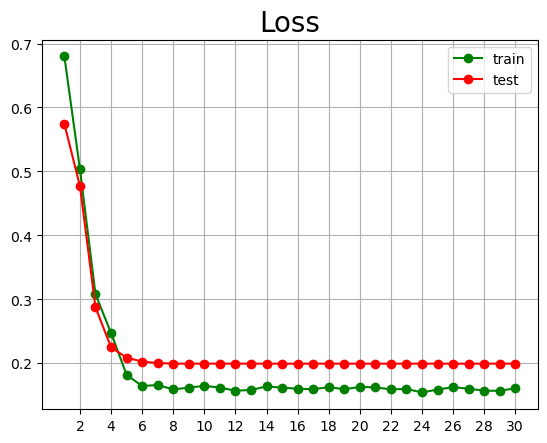

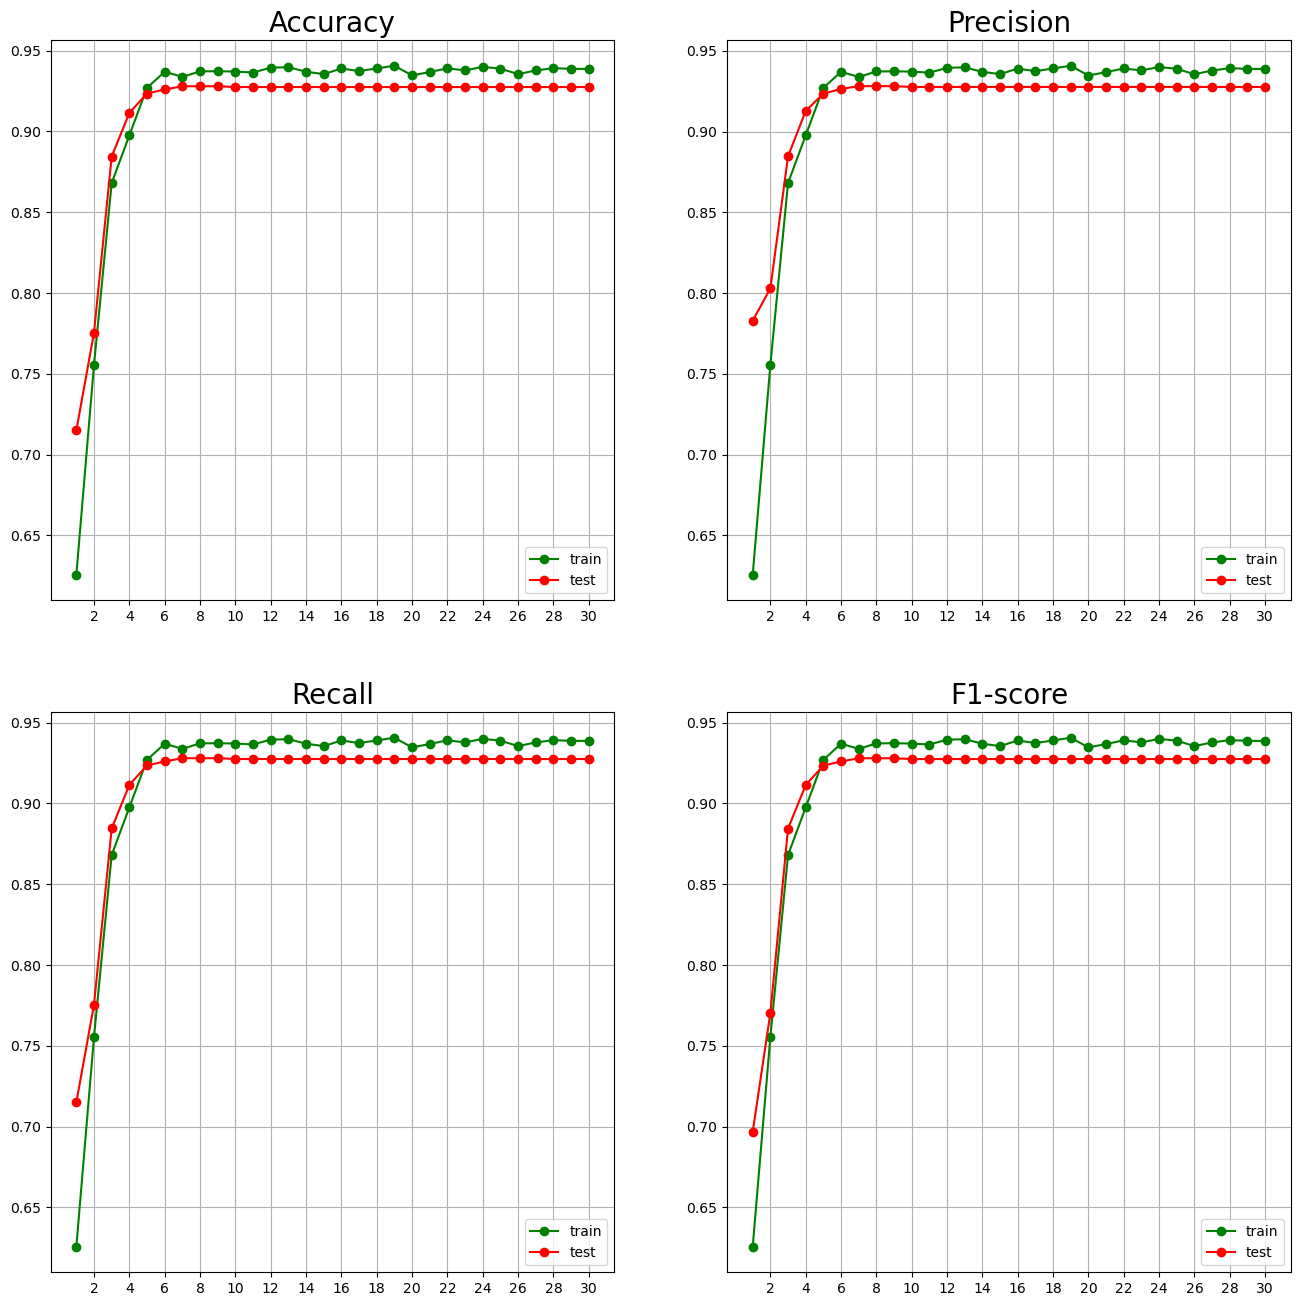

In [15]:

# ## 5.2 Plot


# plot loss
plt.plot(np.arange(1, args.epochs + 1), np.array(train_loss), 'go-')
plt.plot(np.arange(1, args.epochs + 1), np.array(test_loss), 'ro-')
plt.xticks(np.arange(2, args.epochs + 1, 2))
plt.title("Loss")
plt.grid(True)
plt.legend(["train", "test"], loc="upper right")
plt.savefig("../output/Loss.png", dpi=600)


figure = plt.figure(figsize=(16,16))

# plot accuracy
figure.add_subplot(2, 2, 1)
plt.plot(np.arange(1, args.epochs + 1), np.array(train_acc), 'go-')
plt.plot(np.arange(1, args.epochs + 1), np.array(test_acc), 'ro-')
plt.xticks(np.arange(2, args.epochs + 1, 2))
plt.title("Accuracy")
plt.grid(True)
plt.legend(["train", "test"], loc="lower right")
plt.savefig("../output/Accuracy.png", dpi=600)

# plot precision
figure.add_subplot(2, 2, 2)
plt.plot(np.arange(1, args.epochs + 1), np.array(train_precision), 'go-')
plt.plot(np.arange(1, args.epochs + 1), np.array(test_precision), 'ro-')
plt.xticks(np.arange(2, args.epochs + 1, 2))
plt.title("Precision")
plt.grid(True)
plt.legend(["train", "test"], loc="lower right")
plt.savefig("../output/Precision.png", dpi=600)

# plot recall
figure.add_subplot(2, 2, 3)
plt.plot(np.arange(1, args.epochs + 1), np.array(train_recall), 'go-')
plt.plot(np.arange(1, args.epochs + 1), np.array(test_recall), 'ro-')
plt.xticks(np.arange(2, args.epochs + 1, 2))
plt.title("Recall")
plt.grid(True)
plt.legend(["train", "test"], loc="lower right")
plt.savefig("../output/Recall.png", dpi=600)

# plot F1-score
figure.add_subplot(2, 2, 4)
plt.plot(np.arange(1, args.epochs + 1), np.array(train_f1), 'go-')
plt.plot(np.arange(1, args.epochs + 1), np.array(test_f1), 'ro-')
plt.xticks(np.arange(2, args.epochs + 1, 2))
plt.title("F1-score")
plt.grid(True)
plt.legend(["train", "test"], loc="lower right")
plt.savefig("../output/F1-score.png", dpi=600)


In [16]:

for i in range(30):
    torch.cuda.empty_cache()


In [17]:
torch.save(model.state_dict(), '../output/vit_base16_mixed.pth')